In [132]:
import time
import os
import datetime
import random
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import haversine as hs
from haversine import Unit
from shapely.geometry import Point, Polygon
from math import radians, cos, sin, asin, sqrt



In [73]:
trips_df = pd.read_csv("../../../data/mmt_gtfs/trips.csv")
routes_df = pd.read_csv("../../../data/mmt_gtfs/routes.csv")
stops_df = pd.read_csv("../../../data/bus_route_stop_info/stops.csv")
stops_df = stops_df[stops_df["Route"] != "None"]  # filter stops that are not currently in service
stop_times_df = pd.read_csv("../../../data/mmt_gtfs/stop_times.csv")
city = gpd.read_file("../../../data/plot/background/madison-shp")
water = gpd.read_file("../../../data/plot/background/water-shp")
street = gpd.read_file("../../../data/plot/background/streets-shp")

In [4]:
# class Stop:
#
#     def __init__(self, stop_id, stop_name, overlap_route_num,
#                  lat, lon):
#         self.stop_id = stop_id
#         self.stop_name = stop_name
#         self.overlap_route_num = overlap_route_num
#         self.lat = lat
#         self.lon = lon
#         # self.wheelchair_boarding = wheelchair_boarding
#         # maybe consider bike_allowed too?



class Path:

    def __init__(self, stop_sequence, stop_id, distance_traveled):
        self.stop_sequence = stop_sequence
        self.stop_id = stop_id  # stop_id: Stop
        self.distance_traveled = distance_traveled


class Route:

    def __init__(self, route_id, route_num, service_id, color, suspended):
        self.route_id = route_id
        self.route_num = route_num
        self.service_id = service_id
        self.color = color
        self.suspended = suspended  # suspended = True/False due to pandemic

        self.trip_headsign = {}  # trip_id: headsign
        self.headsign_path = {}  # headsign: Path

        # trip_id: [(arrival_time), (departure_time)]
        self.trips_wkd = {}
        self.trips_sat = {}
        self.trips_sun = {}
        self.trips_hol = {}
        self.trips_mwk = {}

    def _init_trip_headsign(self, trip_id, headsign):
        """filling data to trip_headsign"""
        self.trip_headsign[trip_id] = headsign

    def _init_headsign_path(self, headsign, Path):
        """filling data to headsign_path"""
        self.headsign_path[headsign] = Path

    def _init_trip_times(self, trip_id, service_type):
        """filling trip_ids to trip_times dictionaries"""
        service_short = service_type[3:6].lower()
        if service_short == "wkd":
            self.trips_wkd[trip_id] = []
        elif service_short == "sat":
            self.trips_sat[trip_id] = []
        elif service_short == "sun":
            self.trips_sun[trip_id] = []
        elif service_short == "hol":
            self.trips_hol[trip_id] = []
        else:
            self.trips_mwk[trip_id] = []

    def _add_trip_times(self, trip_id, service_type, arrival, departure):
        """filling arrival and departure times to trip_times dictionaries"""
        service_short = service_type[3:6].lower()
        if service_short == "wkd":
            self.trips_wkd[trip_id].extend([arrival, departure])
        elif service_short == "sat":
            self.trips_sat[trip_id].extend([arrival, departure])
        elif service_short == "sun":
            self.trips_sun[trip_id].extend([arrival, departure])
        elif service_short == "hol":
            self.trips_hol[trip_id].extend([arrival, departure])
        else:
            self.trips_mwk[trip_id].extend([arrival, departure])

class MMT:
    """
    MMT is the main class which allows us to manipulate with the data, such as plot
    generation.
    """

    def __init__(self):
        # note:
        # we look at service_id = 92 because the current trip.csv excludes suspended
        # services; service_id = 93 can be later used when we could collect more data.
        # 92 = suspended service excluded; 93 = included
        # (7 & 20 are special cases (only suspended some trips))

        # {route_num: {service_id: Route}}
        self.routes = {route_num: {} for route_num in set(routes_df["route_short_name"])}
        # {stop_id: Stop}
        # self.stops = {}
        self._initialize()
        # self._initialize_Stop()


    def _initialize(self):
        """initialization and extraction of the data"""
        # storing available routes and route info to Route
        for idx, row in routes_df.iterrows():
            suspended = True if "Weekday schedule trips suspended until further notice." \
                        in row["route_desc"] else False
            route_obj = Route(row["route_id"],
                              row["route_short_name"],
                              row["service_id"],
                              row["route_color"],
                              suspended)
            self.routes[row["route_short_name"]][row["service_id"]] = route_obj


        for key1, val1 in self.routes.items():
            trip_sub_df = trips_df[trips_df["route_short_name"].isin([key1])]
            for idx, row in trip_sub_df.iterrows():
                # data record time:
                # - 20200823 - 20201003 for 92, 20201004 - 20201128 for 93
                # - here we'll pick 93
                # service type included: WKD, SAT, SUN, HOL, MWK
                if row["service_id"].startswith("92"):

                    #  filling data to trip_headsign
                    self.routes[key1][92]._init_trip_headsign(row["trip_id"], row["trip_headsign"])

                    # filling trip ids to trip_times dictionaries (e.g. trips_wkd, trips_sat, etc)
                    self.routes[key1][92]._init_trip_times(row["trip_id"], row["service_id"])

                    # filling data to headsign_path
                    stop_times_sub_df = stop_times_df[stop_times_df["trip_id"].isin([row["trip_id"]])]
                    path = Path(list(stop_times_sub_df["stop_sequence"]),
                                list(stop_times_sub_df["stop_id"]),
                                list(stop_times_sub_df["shape_dist_traveled"]))
                    self.routes[key1][92]._init_headsign_path(row["trip_headsign"], path)

                    #  filling arrival and departure times to trip_times dictionaries
                    #  (e.g. trips_wkd, trips_sat, etc)
                    arrival = tuple(stop_times_sub_df["arrival_time"])
                    departure = tuple(stop_times_sub_df["departure_time"])
                    self.routes[key1][92]._add_trip_times(row["trip_id"], row["service_id"],
                                                           arrival, departure)

    # def _initialize_Stop(self):
    #     for idx, row in stops_df.iterrows():
    #         if row["Route"] == "None":
    #             continue
    #         self.stops[row["stop_id"]] = Stop(row["stop_id"],
    #                                           row["stop_name"],
    #                                           list(row["Route"]),
    #                                           row["stop_lat"],
    #                                           row["stop_lon"])

    def get_trips_and_times_by_stop(self, stops, time):
        """

        :param stops: a DataFrame with columns stop_id, lon, lat, distances,
                      generated by the find_nearest function
        :param time: given time in a day, user input
        :return: trip_ids and (arrival_time), (departure_time) that will
                 pass through the stops
        """
        pass




    # TODO: add some functions to here

In [5]:
start = time.time()
madison = MMT()
end = time.time()

print(str(round((end - start) * 1000, 2)) + "ms")

16661.12ms


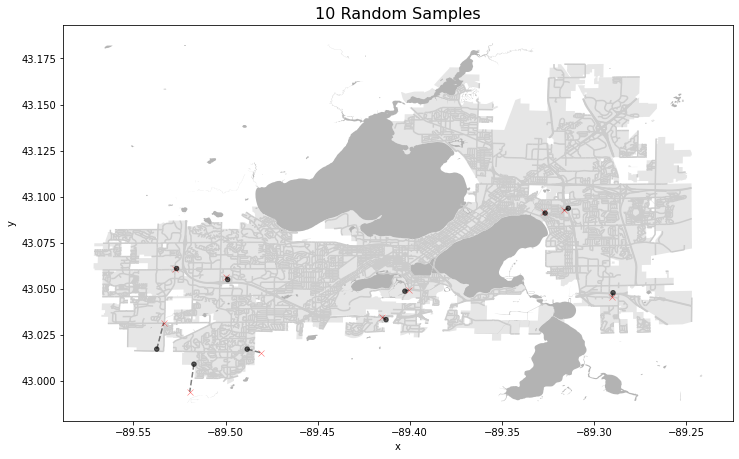

In [201]:
def generate_random(num_points, polygons):
    """
    take as input a numpoints and a list of polygons,
    output a list of points within the given polygons

    :param num_points: number of points generated
    :param polygons: a list of Shapely Polygon
    """
    points = []

    while len(points) < num_points:
        choice = random.choice(range(len(polygons)))
        polygon = polygons[choice]
        minx, miny, maxx, maxy = polygon.bounds
        pnt = Point(random.uniform(round(minx, 2), round(maxx, 2)),
                    random.uniform(round(miny, 2), round(maxy, 2)))
        if polygon.contains(pnt):
            points.append(pnt)
    return points

def plot_random(num_points, ax, **kwargs):
    text_offset = 0.0008
    names = []
    colors = []
    x = []
    y = []
    points = generate_random(num_points, list(city.geometry))
    for idx, p in enumerate(points):

        # randomly generate colors (re-adjust so it's more visibly clear)

        # option 1: generate random colors
        # r = lambda: random.randint(0,255)
        # c = '#%02X%02X%02X' % (r(),r(),r())

        # option 2: all black colors
        c = "k"
        colors.append(c)

        # pt names
        pt_name = "p" + str(idx)
        names.append(pt_name)

        x.append(float(p.x))
        y.append(float(p.y))

        # marking each generated points
        # ax.text(p.x + text_offset, p.y, pt_name, va="bottom", ha="left", c=c)
    df = pd.DataFrame({"name":names, "x":x, "y":y, "color":colors})
    df.plot.scatter("x", "y", ax=ax, c=colors, **kwargs)
    return colors, points


def find_nearest(points):
    """
    Find the nearest bus stops for each point in the points parameter.

    :param points: a list of shapely Point objects
    :return: a DataFrame of columns: stop_id, lon, lat, distance in miles
    """
    ids = []
    lons = []
    lats = []
    dists = []
    for p in points:
        x = p.x
        y = p.y

        # element wise operation to find the smallest value
        euclidean = (stops_df["stop_lon"] - x) ** 2 + (stops_df["stop_lat"] - y) ** 2
        idx = euclidean.idxmin()  # index of the smallest value

        stop_id = stops_df.loc[euclidean.idxmin(), "stop_id"]
        lon = stops_df.loc[euclidean.idxmin(), "stop_lon"]
        lat = stops_df.loc[euclidean.idxmin(), "stop_lat"]
        dist = hs.haversine((x, y), (lon, lat), unit=Unit.MILES)

        ids.append(stop_id)
        lons.append(lon)
        lats.append(lat)
        dists.append(dist)
    stops = pd.DataFrame({
        "stop_id": ids,
        "lon": lons,
        "lat": lats,
        "dist": dists
    })
    return stops

def connect_to_stops(ax, points, stops):
    """
    Draw a line from randomly generated points to nearest bus stops that are in service.

    :param stops: stops dataframe that have columns stop_id, lat, lon, dist
    :param ax: Axes object to plot
    :return: None
    """
    linestrings = []
    for idx, row in stops.iterrows():
        ls = LineString([(points[idx].x, points[idx].y), (row["lon"], row["lat"])])
        linestrings.append(ls)

    df = pd.DataFrame({"geometry":linestrings})
    df.set_geometry("geometry").plot(ax=ax, color="k", linestyle="--", alpha=0.5)

def generate_plot(num_points):
    """
    generate a geo map with randomly generated points, and connect the
    generated points with the nearest bus stops

    :param num_points: number of random points to be generated, user input
    :return: TBD
    """

    # --------- plot background ---------
    fig, ax = plt.subplots(figsize=(12, 10))
    city.plot(ax=ax, color="0.9")
    water.plot(ax=ax, color="0.7")
    street.plot(ax=ax, color="0.8")

    dot_size = 20
    # --------- plot random points ---------
    colors, points = plot_random(num_points=num_points, ax=ax, s=dot_size, zorder=5, alpha=0.6)

    # --------- plot bus stops ---------
    stops = find_nearest(points)
    # stops.plot.scatter("lon", "lat", ax=ax, c=colors, s=35, zorder=5, alpha=0.4, marker='o', facecolor="None")
    plt.plot(stops["lon"],stops["lat"], 'x', markersize=dot_size*0.3, markerfacecolor="None",
             markeredgecolor="red", markeredgewidth=0.5, alpha=0.6)

    # --------- draw lines between pts and stops ---------
    connect_to_stops(ax, points, stops)
    ax.set_title(str(num_points) + " Random Samples", size=16)

    # --------- save figure to file ---------
    return stops
    # TODO: when save, uncomment this
    # ax.set_axis_off()
    #
    # if not os.path.exists("sim_sample"):
    #     os.mkdir("sim_sample")
    #
    # current_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M-%S')
    # dirname = current_time[:current_time.index("_")]
    #
    # if not os.path.exists(os.path.join("sim_sample", dirname)):
    #     os.mkdir(os.path.join("sim_sample", dirname))
    #
    # plt.savefig(os.path.join("sim_sample",
    #                          dirname,
    #                         (current_time[current_time.index("_"):] + ".png")),
    #             dpi=300, bbox_inches="tight")



stops = generate_plot(10)



In [181]:
df = stops.copy()
routes = []
for idx, row in df.iterrows():
    stop_id = row["stop_id"]
    routes.append(stops_df[stops_df["stop_id"].isin([stop_id])]["Route"].iloc[0])
df["routes"] = routes

# if we're looking at the weekday
madison.routes[52][92].trips_wkd.keys(), madison.routes[52][92].trip_headsign






(dict_keys([1012743, 1011905, 1011903, 1011902, 1011901, 1011900, 1011899, 1011898, 1011897, 1011896, 1011895, 1011893, 1011891, 1011890, 1011889, 1011888, 1011887, 1011927, 1011925, 1011923, 1011921, 1011920, 1011919, 1011918, 1011917, 1011916, 1011915, 1011914, 1011912, 1011910, 1011909, 1011908, 1011907, 1011906]),
 {1012743: 'ORCHARD POINT',
  1011905: 'ORCHARD POINT',
  1011903: 'ORCHARD POINT',
  1011902: 'ORCHARD POINT',
  1011901: 'ORCHARD POINT',
  1011900: 'ORCHARD POINT',
  1011899: 'ORCHARD POINT',
  1011898: 'ORCHARD POINT',
  1011897: 'ORCHARD POINT',
  1011896: 'ORCHARD POINT',
  1011895: 'ORCHARD POINT',
  1011893: 'ORCHARD POINT',
  1011891: 'ORCHARD POINT',
  1011890: 'ORCHARD POINT',
  1011889: 'ORCHARD POINT',
  1011888: 'ORCHARD POINT',
  1011887: 'ORCHARD POINT',
  1011927: 'WEST TRANSFER',
  1011925: 'WEST TRANSFER',
  1011923: 'WEST TRANSFER',
  1011921: 'WEST TRANSFER',
  1011920: 'WEST TRANSFER',
  1011919: 'WEST TRANSFER',
  1011918: 'WEST TRANSFER',
  101191